# ПРОЕКТ № 2. АНАЛИЗ ВОРОНКИ

В данной работе анализируется поведение пользователей мобильной игры. Основные этапы прохождения: регистрация, старт обучения, окончание обучения, выбор уровня сложности, выбор пакета вопросов, покупка пакетов вопросов. Цель исследования: определить влияние этапа обучения на прохождение всей игры.

ЗАДАЧИ Проекта:

1. Проверить, отличается ли время прохождения различных этапов для пользователей, которые прошли обучение, от пользователей, не начинавших обучение. Насколько обучение сокращает время прохождения этапов?

2. Посмотреть, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. Нужно доказать, что успешное обучение само по себе влияет на оплату, и без разницы, каким этапом оно шло.

3. Дополнительная задача. Как часто пользователи начинают обучение после того, как они выбрали уровень сложности?

Получаем данные из файлов:

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
warnings.filterwarnings("ignore")
events_df=pd.read_csv('7_4_Events.csv')
purchase_df=pd.read_csv('purchase.csv')

Оставляем только тех пользователей, которые зарегистрировались в 2018 году и с помощью метода info(), получаем информацию о каждом датафрейме:

In [2]:
events_2018=(events_df.start_time>='2018-01-01')&(events_df.start_time<'2019-01-01')&(events_df.event_type=='registration')
registered=events_df[events_2018]['user_id'].to_list()
reg_2018=events_df[events_df.user_id.isin(registered)]
purchase_2018=purchase_df[purchase_df.user_id.isin(registered)]
reg_2018.info()
purchase_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66959 entries, 51405 to 118364
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              66959 non-null  int64  
 1   event_type      66959 non-null  object 
 2   selected_level  8342 non-null   object 
 3   start_time      66959 non-null  object 
 4   tutorial_id     32954 non-null  float64
 5   user_id         66959 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 3.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 1171 to 2778
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1600 non-null   int64 
 1   user_id         1600 non-null   int64 
 2   event_datetime  1600 non-null   object
 3   amount          1600 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 62.5+ KB


In [3]:
print(f'Количество строк без дубликатов в reg_2018: {len(reg_2018.drop_duplicates())} ')
print(f'Количество строк без дубликатов в purchase_2018: {len(purchase_2018.drop_duplicates())}')


Количество строк без дубликатов в reg_2018: 66959 
Количество строк без дубликатов в purchase_2018: 1600


Видим в обоих датафреймах неверный тип у столбцов, содержащих время (object).
Наличие в двух столбцах (selected_level,tutorial_id) пропущенных значений в датафрейме reg_2018. Пропуски в столбце tutorial_id связаны с тем, что запись tutorial_id подразумевается для событий, связанных с обучением. Но для этих событий, отсутствуют параметры выбора уровня сложности selected_level. 
С помощью drop_duplicates убираем дубликаты строк, и видим, что количество строк не изменилось, значит дубликатов не было.


Производим преобразование типов: меняем формат дат в колонках start_time, event_datetime. Переименовываем столбцы, добавляем столбец 'event_type', который будет содержать одно значение purchase.

In [4]:
reg_2018.start_time=pd.to_datetime(reg_2018.start_time, format='%Y-%m-%dT%H:%M:%S')
purchase_2018.event_datetime=pd.to_datetime(purchase_2018.event_datetime, format='%Y-%m-%dT%H:%M:%S')

purchase_2018['event_type'] = 'purchase'
reg_2018 = reg_2018.rename(columns={'id':'event_id'})
purchase_2018 = purchase_2018.rename(columns={'id':'purchase_id', 'event_datetime': 'start_time'})

Объединяем два получившихся датафрейма в один total_events_df:

In [5]:
total_events_df = pd.concat([reg_2018,purchase_2018],sort=False)
total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time')
total_events_df

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN
...,...,...,...,...,...,...,...,...
68554,NaN,purchase,NaN,2019-01-02 03:48:19,NaN,47498,18441.0,100.0
68555,NaN,purchase,NaN,2019-01-02 23:26:26,NaN,47647,18442.0,150.0
68556,NaN,purchase,NaN,2019-01-03 00:36:36,NaN,47554,18443.0,50.0
68557,NaN,purchase,NaN,2019-01-04 12:51:41,NaN,47742,18448.0,50.0


## 1.Проверка первой гипотезы

Для проверки первой гипотезы разделим пользователей на три группы:

-Завершившие обучение (finished);

-Не завершившие обучение (not_finished);

-Без обучения (no_tutorial).

Создаем сводную таблицу с минимальным временем начала каждого события по каждому пользователю:

In [6]:
pivot_df=total_events_df.pivot_table(values='start_time', index='user_id',columns='event_type', aggfunc='min')
pivot_df=pivot_df.reset_index()
pivot_df.head()

event_type,user_id,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start
0,27832,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT
1,27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40
2,27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11
3,27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51
4,27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40


Добавляем к сводной таблице столбец с разделением на группы:

In [7]:
pivot_df['group'] = pivot_df.apply(lambda x: 'finished' if not pd.isnull(x.tutorial_finish) else 'no_tutorial' if pd.isnull(x.tutorial_start) else 'not_finished',axis=1)
pivot_df.head()

event_type,user_id,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start,group
0,27832,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT,no_tutorial
1,27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40,finished
2,27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11,finished
3,27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51,finished
4,27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40,finished


Добавляем столбцы с временем между этапами и сразу приводим их к числовому типу float (так как с объектом timedelta неудобно будет в дальнейшем работать)

In [8]:
pivot_df['timedelta_lc_reg'] = (pivot_df['level_choice'] - pivot_df['registration'])/pd.Timedelta('1 hour')
pivot_df['timedelta_pc_lc'] =( pivot_df['pack_choice'] - pivot_df['level_choice'])/pd.Timedelta('1 hour')
pivot_df['timedelta_p_pc'] = (pivot_df['purchase'] - pivot_df['pack_choice'])/pd.Timedelta('1 hour')
pivot_df['timedelta_p_reg'] = (pivot_df['purchase'] - pivot_df['registration'])/pd.Timedelta('1 hour')
pivot_df.head()

event_type,user_id,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start,group,timedelta_lc_reg,timedelta_pc_lc,timedelta_p_pc,timedelta_p_reg
0,27832,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT,no_tutorial,NaN,NaN,NaN,NaN
1,27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40,finished,NaN,NaN,NaN,NaN
2,27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11,finished,NaN,NaN,NaN,NaN
3,27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51,finished,8.709722,0.0225,NaN,NaN
4,27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40,finished,NaN,NaN,NaN,NaN


Группируем по group и выводим среднее время прохождения каждого этапа (в часах):

In [9]:
grouped_df = pivot_df.groupby(['group'])[['timedelta_lc_reg','timedelta_pc_lc','timedelta_p_pc', 'timedelta_p_reg']].mean().reset_index()
grouped_df

event_type,group,timedelta_lc_reg,timedelta_pc_lc,timedelta_p_pc,timedelta_p_reg
0,finished,7.093571,0.088374,89.299900,96.500902
1,no_tutorial,5.259201,0.089951,100.825997,105.100530
2,not_finished,8.215987,0.084804,93.246363,101.548115


Строим графики по каждому этапу:

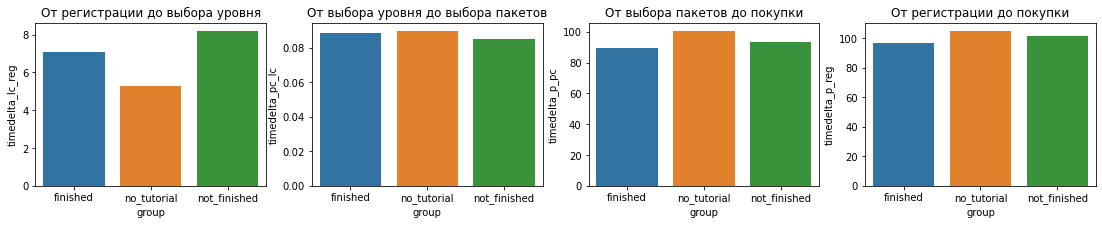

In [10]:
fig, ax =plt.subplots(1,4, figsize=(19,3))
sns.barplot(x = 'group', y = 'timedelta_lc_reg', data = grouped_df, ax=ax[0])
ax[0].set_title('От регистрации до выбора уровня')
sns.barplot(x = 'group', y = 'timedelta_pc_lc', data = grouped_df, ax=ax[1])
ax[1].set_title('От выбора уровня до выбора пакетов')
sns.barplot(x = 'group', y = 'timedelta_p_pc', data = grouped_df,ax=ax[2])
ax[2].set_title('От выбора пакетов до покупки')
sns.barplot(x = 'group', y = 'timedelta_p_reg', data = grouped_df,ax=ax[3])
ax[3].set_title('От регистрации до покупки')
fig.show()

## Выводы по первой гипотезе
Как видно из таблицы и на графике, по первому временному промежутку между регистрацией и выбором уровня сложности наименьшее время у группы, не проходившей обучение (около 5 часов, тогда как у закончивших обучение 7 часов). Что логично, так как они не тратят время на обучение, как две другие группы. Временной промежуток от выбора уровня до выбора пакетов для каждой из групп ничтожно мал и примерно одинаков (примерно 5 минут). Время от выбора пакетов до покупки представляет наибольший интерес, так как покупка для нас самый важный этап. Наибольшее время (100 часов) у группы , не проходившей обучение. Это значит, что без обучения пользователи дольше решаются на покупку. И минимальное время у группы, окончевший обучение - 89 часов. И на последнем графике видно, что наибольшее общее время от регистрации до покупки у группы без обучения (105 часов). Получается, что обучение сокращает общее время до покупки на 8,6 часов. Значит гипотеза подтверждается: прохождение обучения влияет на итоговое время от регистрации до покупки. 

## 2.Проверка второй гипотезы

Для проверки гипотезы выделим группы пользователей по количеству обучений, которые они закончили

In [11]:
tutorial_count=total_events_df[total_events_df.event_type=='tutorial_finish'].user_id.value_counts().reset_index().rename(columns={'index':'user_id','user_id':'tutorial_count'})
tutorial_count

,user_id,tutorial_count
0,29630,9
1,41227,9
2,39496,9
3,41413,9
4,44276,9
...,...,...
10245,46509,1
10246,34824,1
10247,43020,1
10248,40973,1


Добавим еще один столбец с отметкой о покупке

In [12]:
purchas=total_events_df[total_events_df.event_type=='purchase'].user_id.value_counts().reset_index().rename(columns={'index':'user_id','user_id':'purchase'})
tutorial_purchase=tutorial_count.merge(purchas, on='user_id', how='left')
tutorial_purchase['purchase']=tutorial_purchase['purchase'].apply(lambda x:'purchase' if x>0 else 'no_purchase')
tutorial_purchase.head()

,user_id,tutorial_count,purchase
0,29630,9,purchase
1,41227,9,no_purchase
2,39496,9,no_purchase
3,41413,9,purchase
4,44276,9,no_purchase


Создадим сводную таблицу, в которой сведем данные по признаку покупки и количествам обучений:

In [13]:
pivot2=tutorial_purchase.pivot_table(index='tutorial_count', columns='purchase',values='user_id', aggfunc='nunique')
pivot2

purchase,no_purchase,purchase
tutorial_count,,
1,6872,1143
2,1139,182
3,301,44
4,159,19
5,98,19
6,86,15
7,82,15
8,48,6
9,18,4


Строим графики по сводной таблице

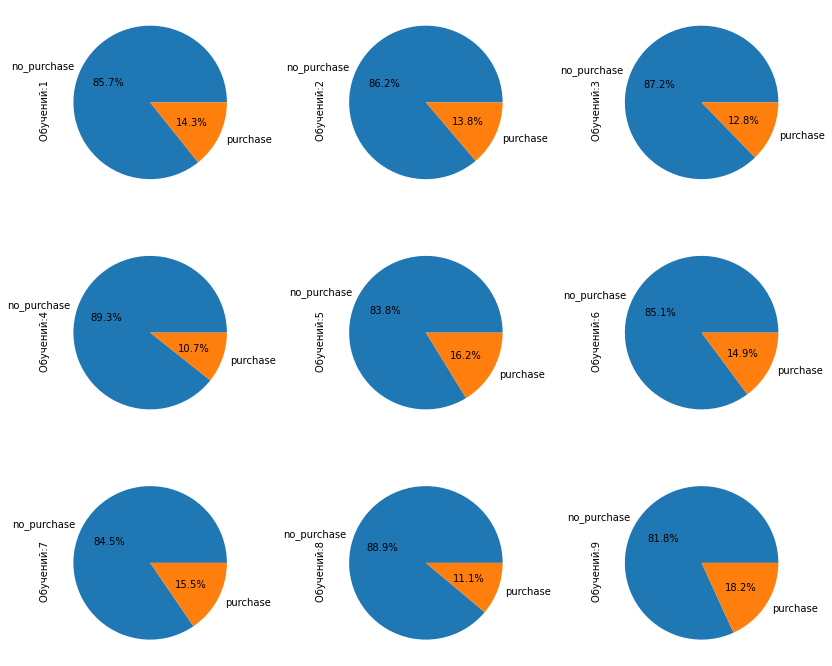

In [14]:
fig, ax=plt.subplots(3, 3,figsize=(14, 12))
for i  in pivot2.index:
            j = (i-1) // 3 
            k = (i-1) - j*3
            pivot2.iloc[i-1].plot(kind='pie',autopct='%1.1f%%',ax=ax[j][k], label=f"Обучений:{i}     ")

Дополнительно рассчитаем, какой процент пользователей из тех, что не начинали ни одного обучения, совершает покупки (для сравнения):

In [15]:
users_registered =set(total_events_df[total_events_df['event_type'] == 'registration']['user_id'].unique())
users_with_started_tutorial = set(total_events_df[total_events_df['event_type'] == 'tutorial_start']['user_id'].unique())
not_started_tutorial=list(users_registered-users_with_started_tutorial)
total_events_df1=total_events_df[(total_events_df.event_type=='purchase')&(total_events_df.user_id.isin(not_started_tutorial))]
percent_of_purchase_1 =total_events_df1.user_id.nunique()/len(not_started_tutorial)
print ('Процент пользователей, которые оплатили (от числа пользователей, не начинавших обучение): {:.2%}'.format(percent_of_purchase_1))

Процент пользователей, которые оплатили (от числа пользователей, не начинавших обучение): 0.27%


## Выводы по второй гипотезе:
В ходе анализа было выявлено, что процент оплат по группам в зависимости от количества обучений примерно одинаков (от 10% до 20%). То есть конверсия для тех, кто прошел обучение 1 раз и 9 раз не сильно отличается, значит можно сказать, что успешное обучение само по себе влияет на оплату. Для сравнения была рассчитана конверсия оплат для тех, кто не начинал ни одного обучения. Для этой группы процент оплативших - 0,27%. Что еще раз подтверждает, что обучение влияет на дальнейшую покупку, соответственно необходимо привлекать пользователей проходить обучение.

## 3.Проверка третьей гипотезы

Для этого отдельно сформируем датафрейм с отбором по событию - tutorial_start, сгруппировав по пользователям, выведем максимальное время начала обучения.
И второй датафрейм с отбором по событию - level_choice, сгруппировав по пользователям.
Объединим эти два датафрейма в одну таблицу time:

In [16]:
tutorial_start_time=total_events_df[total_events_df['event_type'] == 'tutorial_start'].groupby(['user_id']).start_time.max().reset_index().rename(columns={'start_time': 'start_time_Tut'})
levelch_start_time=total_events_df[total_events_df['event_type'] == 'level_choice'].groupby(['user_id']).start_time.min().reset_index().rename(columns={'start_time': 'start_time_LC'})
time=levelch_start_time.merge(tutorial_start_time, on='user_id', how='inner')
time.head()

,user_id,start_time_LC,start_time_Tut
0,27835,2018-01-01 20:37:22,2018-01-01 15:00:51
1,27839,2018-01-01 22:37:50,2018-01-01 19:11:36
2,27840,2018-01-02 05:18:42,2018-01-02 02:07:07
3,27842,2018-01-02 08:46:03,2018-01-02 18:08:01
4,27843,2018-01-02 14:09:58,2018-01-02 13:34:51


Выведем только тех, у кого время начала обучения больше времени выбора уровня:

In [17]:
tutorial_after_lc_count=time[time['start_time_LC']<time['start_time_Tut']].user_id.nunique()
level_choice_users_count = total_events_df[total_events_df['event_type'] == 'level_choice']['user_id'].nunique()
print(f'Начали обучение после выбора уровня {tutorial_after_lc_count} пользователей. А всего пользователей, выбравших уровень {level_choice_users_count}.')
print('Процент пользователей, перешедших к обучению после выбора уровня сложности  (от общего числа выбравших уровень): {:.2%}'.format(tutorial_after_lc_count/level_choice_users_count))

Начали обучение после выбора уровня 1386 пользователей. А всего пользователей, выбравших уровень 8342.
Процент пользователей, перешедших к обучению после выбора уровня сложности  (от общего числа выбравших уровень): 16.61%


## Выводы по третьей гипотезе:
По полученным данным видим, что 1386 пользователей возвращаются к обучению после выбора уровня сложности, что составляет 16% от общего числа выбравших уровень сложности. Это означает, что части пользователям работа с приложением непонятна, соответвенно требует доработки.